In [21]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("datasets/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
X = df.drop(columns=['target'])
y = df['target']


In [12]:
len(y[y == 0])/len(y)

0.45544554455445546

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=52)

In [9]:
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=52)
decision_tree.fit(X_train, y_train)

y_train_pred = decision_tree.predict(X_train)
y_pred = decision_tree.predict(X_test)

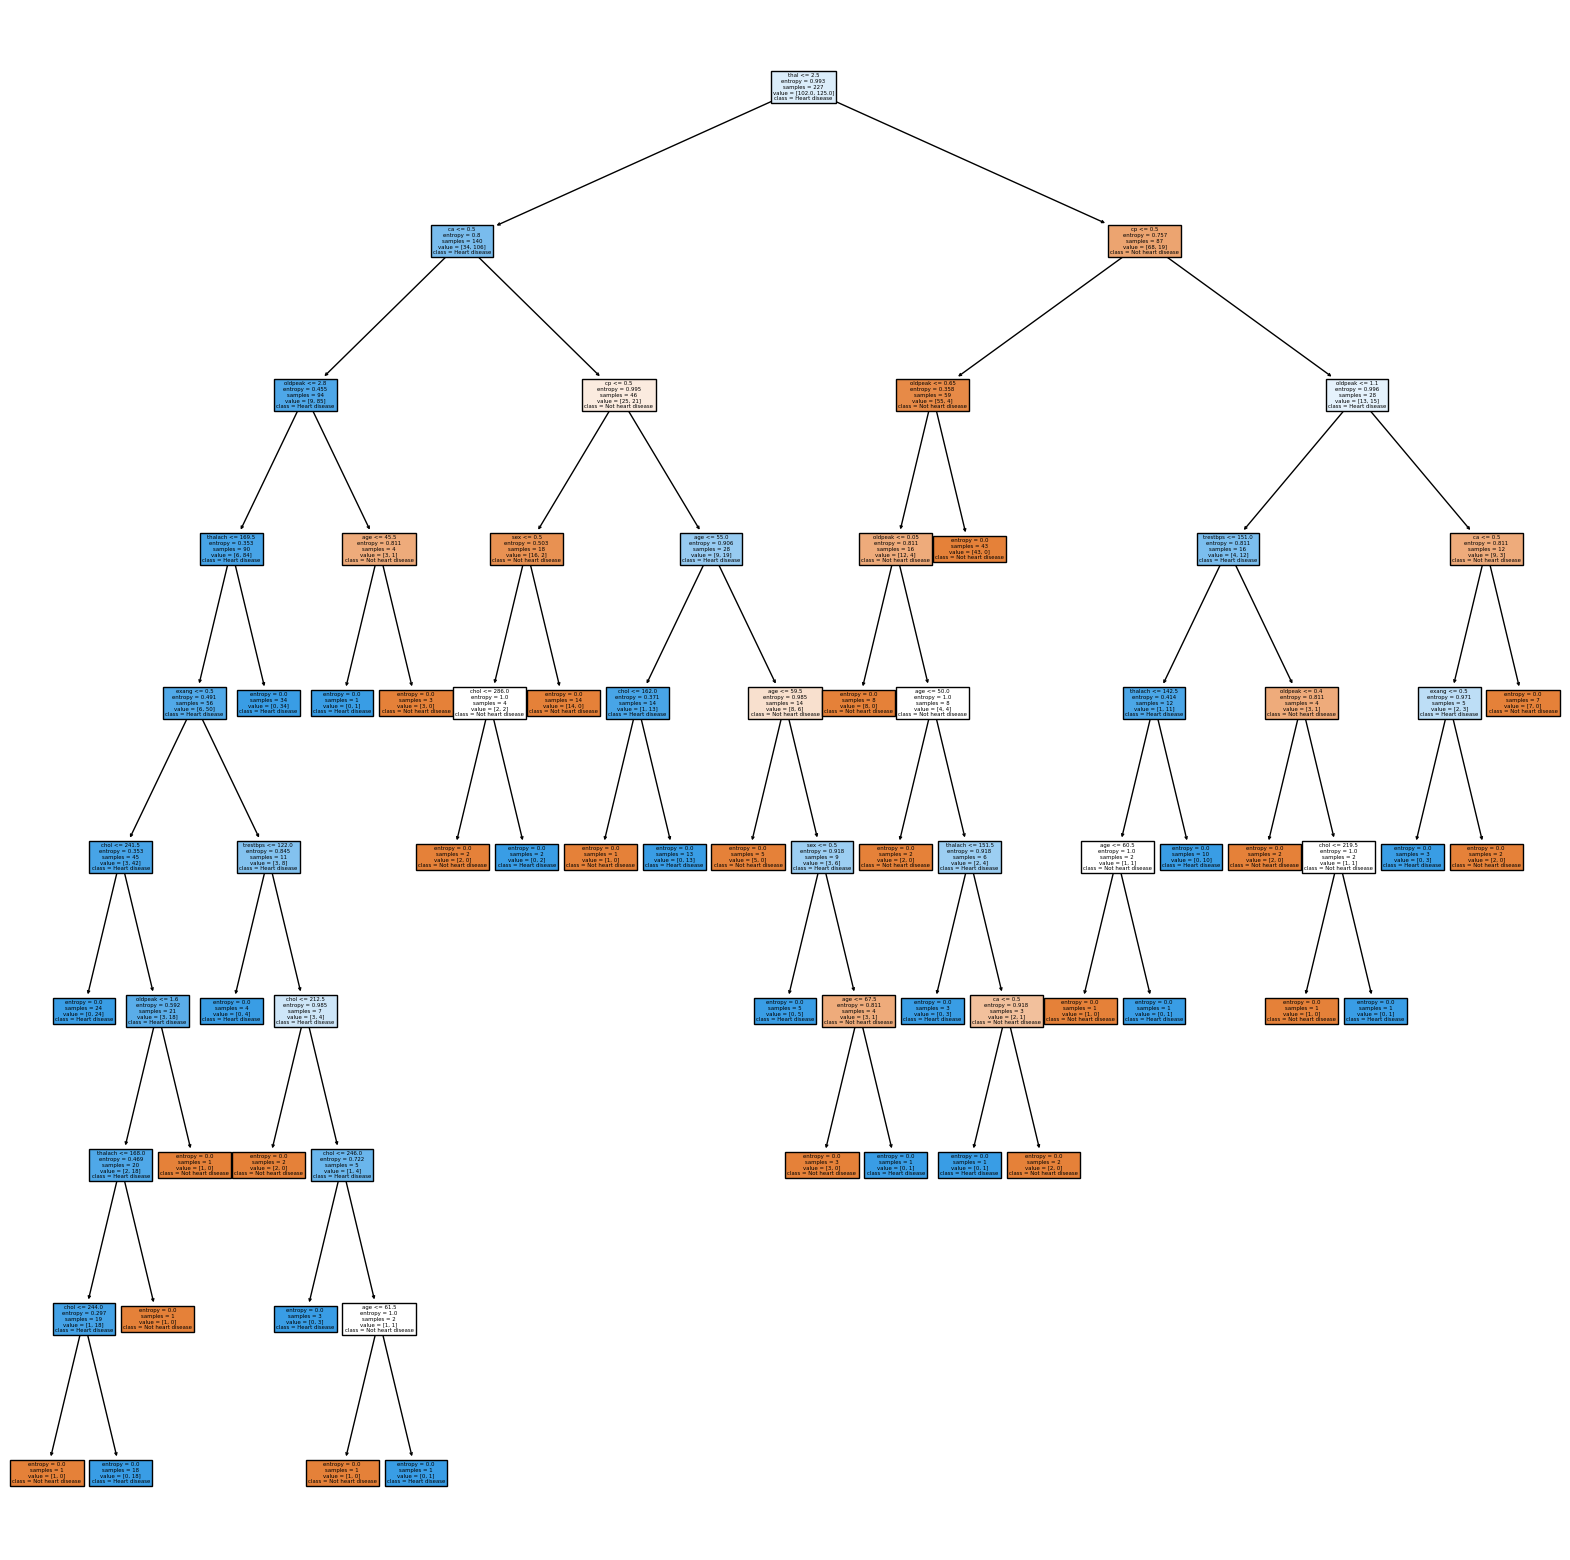

In [7]:
from textwrap import fill


plt.figure(figsize=(20, 20))
features = df.columns
classes = ['Not heart disease', 'Heart disease']
tree.plot_tree(decision_tree=decision_tree, feature_names=features, class_names=classes, filled=True)
plt.show()

Train score 1.0
Test score 0.7236842105263158
Train Confusion matrix


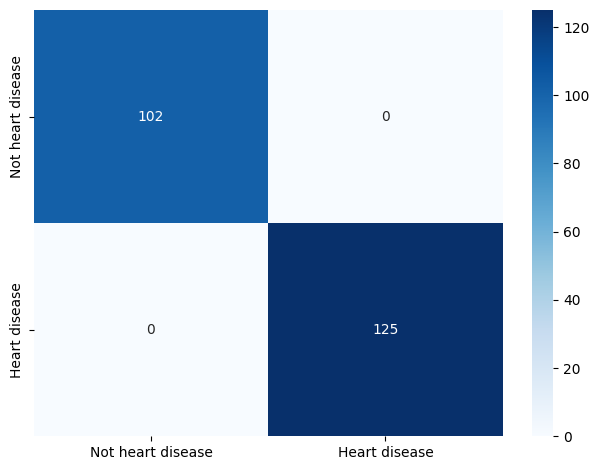

Test Confusion matrix


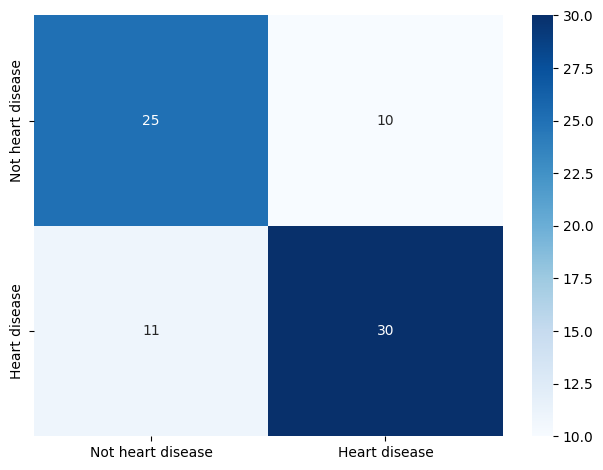

In [10]:
# helper function
def plot_confusionmatrix(y_train_pred, y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()
    
    
print(f'Train score {accuracy_score(y_train_pred, y_train)}')
print(f'Test score {accuracy_score(y_pred, y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_pred,y_test,dom='Test')

In [13]:
# Pre pruning
params = {'max_depth': [2,4,6,8,10,12,14,16],
          'min_samples_split': [2,3,4,5,6],
          'min_samples_leaf': [1,2,4]}
decision_tree = tree.DecisionTreeClassifier(random_state=52)
grid_search = GridSearchCV(estimator=decision_tree, param_grid=params)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=52),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 3, 4, 5, 6]})

Train score 0.9251101321585903
Test score 0.7631578947368421
Train Confusion matrix


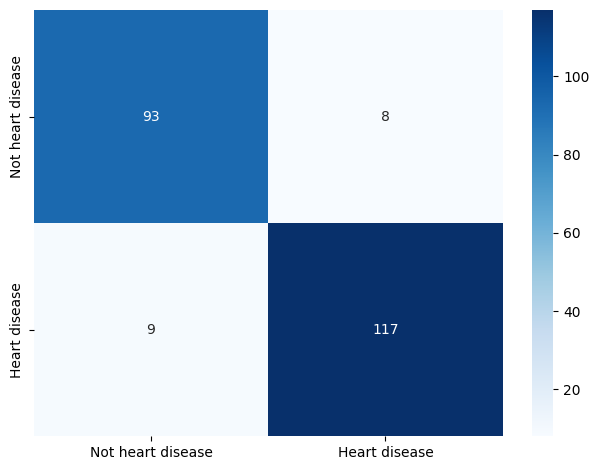

Test Confusion matrix


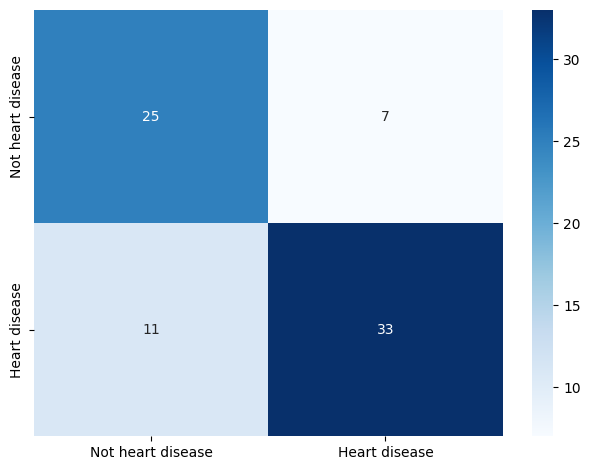

In [15]:
model = grid_search.best_estimator_
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

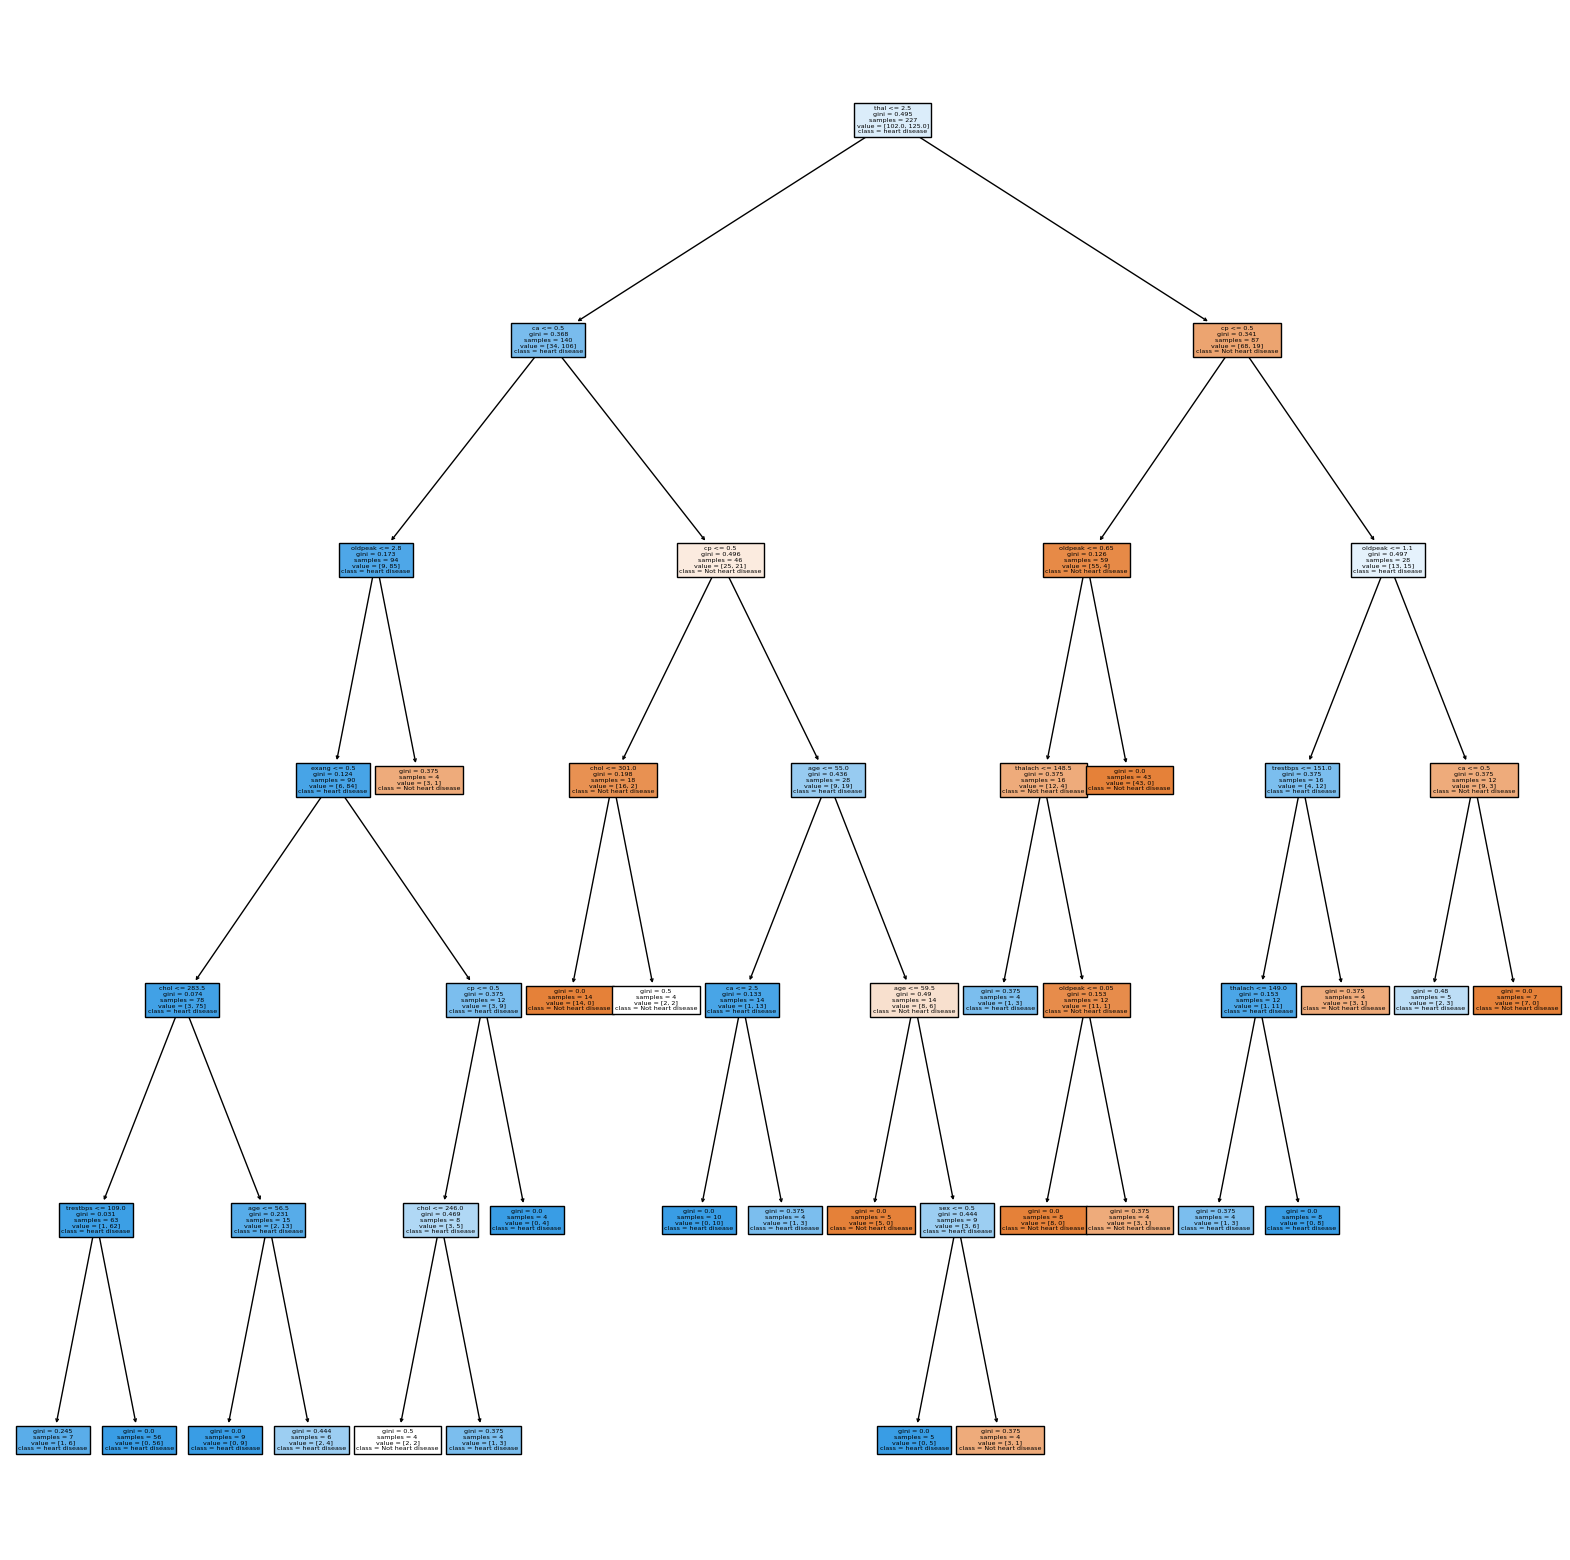

In [16]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not heart disease','heart disease']
tree.plot_tree(model,feature_names=features,class_names=classes,filled=True)
plt.show()


In [18]:
# Post pruning
# Cost-complexity pruning
from scipy.fftpack import cc_diff


path = decision_tree.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas, impurities)

[0.         0.00330396 0.00391581 0.00403818 0.00403818 0.00423585
 0.00536416 0.00660793 0.00660793 0.00660793 0.00783162 0.00818125
 0.00908435 0.00991189 0.01101322 0.01174743 0.01258653 0.01510384
 0.0154185  0.01575593 0.03108478 0.03662974 0.0545508  0.13721559] [0.         0.00660793 0.01443955 0.02251591 0.03059227 0.05600738
 0.07209985 0.07870778 0.08531571 0.09192364 0.10758688 0.11576813
 0.13393682 0.15376061 0.16477383 0.17652126 0.18910779 0.20421163
 0.21963013 0.23538606 0.26647084 0.30310058 0.35765138 0.49486697]


In [22]:
# For each alpha we will append our model to a list
decision_trees = []
for ccp_alpha in ccp_alphas:
    decision_tree = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    decision_tree.fit(X_train, y_train)
    decision_trees.append(decision_tree)

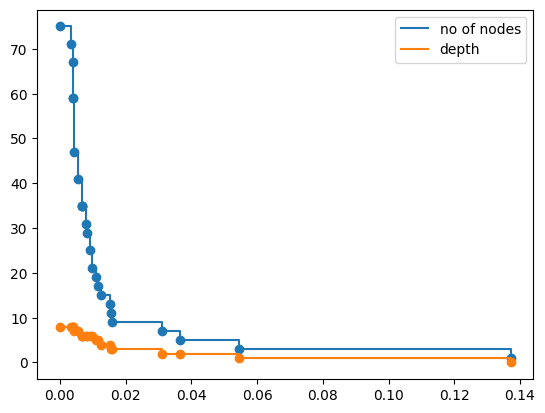

In [24]:
node_counts = [clf.tree_.node_count for clf in decision_trees]
depth = [clf.tree_.max_depth for clf in decision_trees]

plt.scatter(ccp_alphas, node_counts)
plt.scatter(ccp_alphas, depth)
plt.plot(ccp_alphas, node_counts, label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas, depth, label='depth',drawstyle="steps-post")

plt.legend()
plt.show()


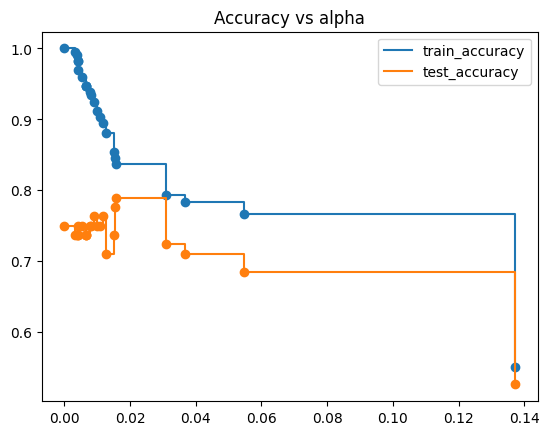

In [25]:
train_acc = []
test_acc = []
for c in decision_trees:
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

Train score 0.8370044052863436
Test score 0.7894736842105263
Train Confusion matrix


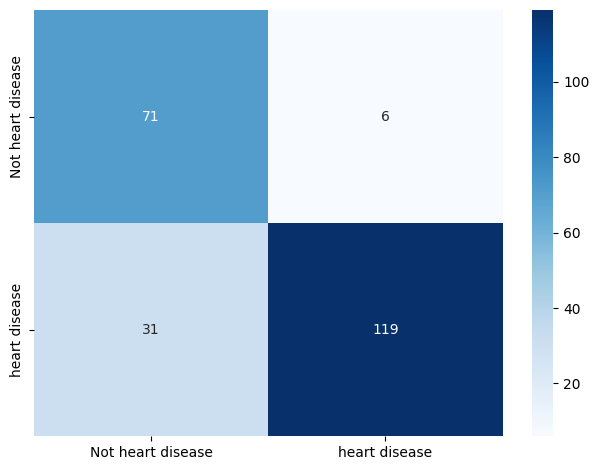

Test Confusion matrix


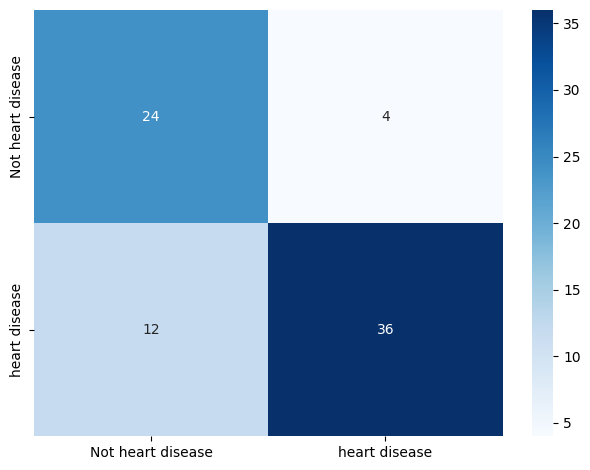

In [27]:
ALPHA = 0.02

clf_ = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ALPHA)
clf_.fit(X_train,y_train)
y_train_pred = clf_.predict(X_train)
y_test_pred = clf_.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')